## Packages

In [3]:
from pathlib import Path
import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from ucimlrepo import fetch_ucirepo, list_available_datasets
from yellowbrick.classifier import DiscriminationThreshold

set_config(display='diagram')
pd.set_option("display.max_columns", None)

# Data collection

In [4]:
HOME_DIR = Path("data")
DATA_TRAIN = HOME_DIR / "training.csv"
HOME_DIR.mkdir(parents=True, exist_ok=True)

Work directory: C:\Users\HP\Desktop\Livrables_groupe6\DATA 
Data directory: C:\Users\HP\Desktop\Livrables_groupe6\DATA\training.csv


# Modeling

## Régression logistique

### baseline

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# ----------------------------
# 1. Séparation des variables
# ----------------------------
X = df.drop('FraudResult', axis=1)
y = df['FraudResult']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# 2. Prétraitement
# ----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
])

# ----------------------------
# 0. Baseline (modèle par défaut)
# ----------------------------
print("📌 Baseline : Régression Logistique sans tuning ni sampling")

baseline_pipeline = ImbPipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(random_state=42))
])

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_val)
y_proba_baseline = baseline_pipeline.predict_proba(X_val)[:, 1]

print("➡️ Performance du modèle baseline :")
print(f"Accuracy  : {accuracy_score(y_val, y_pred_baseline):.4f}")
print(f"Précision : {precision_score(y_val, y_pred_baseline, zero_division=0):.4f}")
print(f"Rappel    : {recall_score(y_val, y_pred_baseline):.4f}")
print(f"F1-score  : {f1_score(y_val, y_pred_baseline):.4f}")
print(f"ROC AUC   : {roc_auc_score(y_val, y_proba_baseline):.4f}")
# ----------------------------
# Affichage des hyperparamètres par défaut
# ----------------------------
print("\n📋 Hyperparamètres par défaut de la Régression Logistique :")
for param, val in baseline_pipeline.named_steps['clf'].get_params().items():
    print(f"{param}: {val}")


📌 Baseline : Régression Logistique sans tuning ni sampling
➡️ Performance du modèle baseline :
Accuracy  : 0.9982
Précision : 0.6000
Rappel    : 0.3621
F1-score  : 0.4516
ROC AUC   : 0.9943

📋 Hyperparamètres par défaut de la Régression Logistique :
C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: deprecated
n_jobs: None
penalty: l2
random_state: 42
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False


### Tuning and sampling with regression logistique

In [57]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# ----------------------------
# 1. Séparation des variables
# ----------------------------
X = df.drop('FraudResult', axis=1)
y = df['FraudResult']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# 2. Prétraitement dans un transformer unique
# ----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
])

# ----------------------------
# 3. Paramètres de recherche pour RandomForest et sampling
# ----------------------------
# Paramètres de base du classifieur
param_grid = {
    'clf__penalty': ['l2'],
    'clf__C': [0.1, 10],
    'clf__solver': ['lbfgs'],
    'clf__max_iter': [6000]
}

# Paramètres avec suréchantillonnage SMOTE
param_grid_smote = param_grid.copy()
param_grid_smote.update({
    'smote__sampling_strategy': [0.25, 0.5]
})

# Paramètres avec sous-échantillonnage
param_grid_under = param_grid.copy()
param_grid_under.update({
    'under__sampling_strategy': [0.25, 0.5]
})

# ----------------------------
# 4. Pipelines avec différentes méthodes
# ----------------------------
pipelines = {
    "Original": ImbPipeline([
        ('preproc', preprocessor),
        ('clf', LogisticRegression())
    ]),
    "SMOTE": ImbPipeline([
        ('preproc', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression())
    ]),
    "UnderSampling": ImbPipeline([
        ('preproc', preprocessor),
        ('under', RandomUnderSampler(random_state=42)),
        ('clf', LogisticRegression())
    ]),
    "Pondération": ImbPipeline([
        ('preproc', preprocessor),
        ('clf', LogisticRegression(class_weight='balanced'))
    ])
}

# ----------------------------
# 5. Entraînement et évaluation
# ----------------------------
resultats = []


for methode, pipeline in pipelines.items():
    print(f"\n🔍 Méthode : {methode}")

    if "SMOTE" in methode:
        tuned_parameters = param_grid_smote
    elif "UnderSampling" in methode:
        tuned_parameters = param_grid_under
    else:
        tuned_parameters = param_grid
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    
    grid = GridSearchCV(pipeline, tuned_parameters, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
    grid.fit(X_train, y_train)

    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    y_proba = best_model.predict_proba(X_val)[:, 1]

    resultats.append({
        'Méthode': methode,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Précision': precision_score(y_val, y_pred, zero_division=0),
        'Rappel': recall_score(y_val, y_pred),
        'F1-score': f1_score(y_val, y_pred),
        'ROC AUC': roc_auc_score(y_val, y_proba),
        'Best Params': grid.best_params_
    })

# ----------------------------
# 6. Résumé des résultats
# ----------------------------
df_resultats = pd.DataFrame(resultats)
df_resultats = df_resultats.sort_values(by='F1-score', ascending=False).reset_index(drop=True)

print("\n📊 Résumé des performances pour regression logistique:")
print(df_resultats)



🔍 Méthode : Original

🔍 Méthode : SMOTE

🔍 Méthode : UnderSampling

🔍 Méthode : Pondération

📊 Résumé des performances pour regression logistique:
         Méthode  Accuracy  Précision    Rappel  F1-score   ROC AUC  \
0  UnderSampling  0.997352   0.429688  0.948276  0.591398  0.998690   
1          SMOTE  0.995993   0.327273  0.931034  0.484305  0.997477   
2       Original  0.998188   0.583333  0.362069  0.446809  0.997757   
3    Pondération  0.991254   0.181518  0.948276  0.304709  0.997635   

                                         Best Params  
0  {'clf__C': 0.1, 'clf__max_iter': 6000, 'clf__p...  
1  {'clf__C': 10, 'clf__max_iter': 6000, 'clf__pe...  
2  {'clf__C': 0.1, 'clf__max_iter': 6000, 'clf__p...  
3  {'clf__C': 0.1, 'clf__max_iter': 6000, 'clf__p...  


## récupérer le pipeline optimal pour regression logistique

In [59]:
# Recréer le pipeline avec les meilleurs paramètres
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Meilleurs hyperparamètres
best_params = df_resultats[df_resultats['Méthode'] == 'UnderSampling']['Best Params'].values[0]
# Reconstruire le pipeline final
best_pipeline_regressin_logistique = ImbPipeline([
    ('preproc', preprocessor),
    ('under', RandomUnderSampler(sampling_strategy=best_params['under__sampling_strategy'], random_state=42)),
    ('clf', LogisticRegression(
        penalty=best_params['clf__penalty'],
        C=best_params['clf__C'],
        solver=best_params['clf__solver'],
        max_iter=best_params['clf__max_iter']
    ))
])


# Entraîner le pipeline final
print("best hyperam", best_params)
best_pipeline_regressin_logistique.fit(X_train, y_train)


best hyperam {'clf__C': 0.1, 'clf__max_iter': 6000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'under__sampling_strategy': 0.25}


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Value',
                                                   'SubscriptionId_transaction_count',
                                                   'CustomerId_abs_amount_std',
                                                   'log_CustomerId_abs_amount_sum',
                                                   'Amount_Value_Ecart']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['ProviderId', 'ProductId', 'ChannelId', 'PricingStrategy',
       'TransactionType', 'TransactionDay', 'MomentOfDay'],
      dtype='object'))])),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.25)),
                ('clf', LogisticRegression(C=0.1, max_iter=6000))])

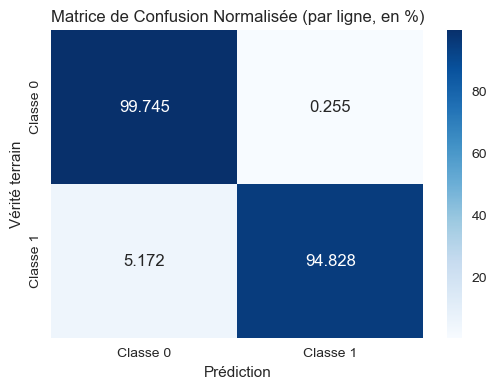

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.43      0.95      0.59        58

    accuracy                           1.00     28699
   macro avg       0.71      0.97      0.80     28699
weighted avg       1.00      1.00      1.00     28699



In [60]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prédictions du modèle
y_pred = best_pipeline_regressin_logistique.predict(X_val)

# 2. Matrice de confusion normalisée par ligne (pourcentage par classe réelle)
conf_matrix_normalized = confusion_matrix(y_val, y_pred, normalize='true') * 100  # en %

# 3. Affichage de la matrice de confusion normalisée
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matrice de Confusion Normalisée (par ligne, en %)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

# 4. Affichage du rapport de classification
print("Rapport de classification :\n", classification_report(y_val, y_pred))


In [61]:
import dill

# Enregistrer le meilleur modèle avec dill
with open('best_Regression_logistique.dill', 'wb') as f:
    dill.dump(best_pipeline_regressin_logistique, f)
    
# Charger le modèle avec dill
with open('best_Regression_logistique.dill', 'rb') as f:
    loaded_model = dill.load(f)
# Effectuer une prédiction pour tester le modèle chargé
y_pred = loaded_model.predict(X_val)
print(y_pred)


[0 0 0 ... 0 0 0]


## KNN

## Baseline

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# ----------------------------
# 1. Séparation des variables
# ----------------------------
X = df.drop('FraudResult', axis=1)
y = df['FraudResult']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# 2. Prétraitement
# ----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
])

# ----------------------------
# 0. Baseline (modèle par défaut)
# ----------------------------
print("📌 Baseline : K-Nearest Neighbors sans tuning ni sampling")

baseline_pipeline = ImbPipeline([
    ('preproc', preprocessor),
    ('clf', KNeighborsClassifier())
])

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_val)
y_proba_baseline = baseline_pipeline.predict_proba(X_val)[:, 1]

print("➡️ Performance du modèle baseline :")
print(f"Accuracy  : {accuracy_score(y_val, y_pred_baseline):.4f}")
print(f"Précision : {precision_score(y_val, y_pred_baseline, zero_division=0):.4f}")
print(f"Rappel    : {recall_score(y_val, y_pred_baseline):.4f}")
print(f"F1-score  : {f1_score(y_val, y_pred_baseline):.4f}")
print(f"ROC AUC   : {roc_auc_score(y_val, y_proba_baseline):.4f}")

# ----------------------------
# Affichage des hyperparamètres par défaut
# ----------------------------
print("\n📋 Hyperparamètres par défaut de K-Nearest Neighbors :")
for param, val in baseline_pipeline.named_steps['clf'].get_params().items():
    print(f"{param}: {val}")


📌 Baseline : K-Nearest Neighbors sans tuning ni sampling
➡️ Performance du modèle baseline :
Accuracy  : 0.9991
Précision : 0.8667
Rappel    : 0.6724
F1-score  : 0.7573
ROC AUC   : 0.9567

📋 Hyperparamètres par défaut de K-Nearest Neighbors :
algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 5
p: 2
weights: uniform


### Tuning and sampling with KNN

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# ----------------------------
# 1. Séparation des variables
# ----------------------------
X = df.drop('FraudResult', axis=1)
y = df['FraudResult']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# 2. Prétraitement dans un transformer unique
# ----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
])

# ----------------------------
# 3. Paramètres de recherche pour KNN et sampling
# ----------------------------
# Paramètres de base du classifieur KNN
param_grid = {
    'clf__n_neighbors': [3, 10],
    'clf__metric': ['minkowski', 'euclidean'],
    'clf__weights': ['uniform', 'distance'],
}

# Paramètres avec suréchantillonnage SMOTE
param_grid_smote = param_grid.copy()
param_grid_smote.update({
    'smote__sampling_strategy': [0.25, 0.5]
})

# Paramètres avec sous-échantillonnage
param_grid_under = param_grid.copy()
param_grid_under.update({
    'under__sampling_strategy': [0.25, 0.5]
})

# ----------------------------
# 4. Pipelines avec différentes méthodes
# ----------------------------
pipelines = {
    "Original": ImbPipeline([
        ('preproc', preprocessor),
        ('clf', KNeighborsClassifier())
    ]),
    "SMOTE": ImbPipeline([
        ('preproc', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', KNeighborsClassifier())
    ]),
    "UnderSampling": ImbPipeline([
        ('preproc', preprocessor),
        ('under', RandomUnderSampler(random_state=42)),
        ('clf', KNeighborsClassifier())
    ]),
    "Pondération": ImbPipeline([
        ('preproc', preprocessor),
        ('clf', KNeighborsClassifier(weights='uniform'))  # "uniform" pour l'équilibre des poids
    ])
}

# ----------------------------
# 5. Entraînement et évaluation
# ----------------------------
resultats_knn = []

for methode, pipeline in pipelines.items():
    print(f"\n🔍 Méthode : {methode}")

    if "SMOTE" in methode:
        tuned_parameters = param_grid_smote
    elif "UnderSampling" in methode:
        tuned_parameters = param_grid_under
    else:
        tuned_parameters = param_grid
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    
    grid = GridSearchCV(pipeline, tuned_parameters, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    y_proba = best_model.predict_proba(X_val)[:, 1]

    resultats_knn.append({
        'Méthode': methode,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Précision': precision_score(y_val, y_pred, zero_division=0),
        'Rappel': recall_score(y_val, y_pred),
        'F1-score': f1_score(y_val, y_pred),
        'ROC AUC': roc_auc_score(y_val, y_proba),
        'Best Params': grid.best_params_
    })

# ----------------------------
# 6. Résumé des résultats
# ----------------------------
df_resultats_knn = pd.DataFrame(resultats_knn)
df_resultats_knn = df_resultats_knn.sort_values(by='F1-score', ascending=False).reset_index(drop=True)

print("\n📊 Résumé des performances pour K-Nearest Neighbors :")
print(df_resultats_knn)



🔍 Méthode : Original

🔍 Méthode : SMOTE

🔍 Méthode : UnderSampling

🔍 Méthode : Pondération

📊 Résumé des performances pour K-Nearest Neighbors :
         Méthode  Accuracy  Précision    Rappel  F1-score   ROC AUC  \
0          SMOTE  0.999059   0.746032  0.810345  0.776860  0.965245   
1       Original  0.999059   0.816327  0.689655  0.747664  0.922274   
2    Pondération  0.999059   0.816327  0.689655  0.747664  0.922274   
3  UnderSampling  0.993519   0.233333  0.965517  0.375839  0.980774   

                                         Best Params  
0  {'clf__metric': 'minkowski', 'clf__n_neighbors...  
1  {'clf__metric': 'minkowski', 'clf__n_neighbors...  
2  {'clf__metric': 'minkowski', 'clf__n_neighbors...  
3  {'clf__metric': 'minkowski', 'clf__n_neighbors...  


## récupérer le pipeline optimal pour KNN

In [68]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier

# Meilleurs hyperparamètres obtenus par SMOTE
best_params = df_resultats_knn[df_resultats_knn['Méthode'] == 'SMOTE']['Best Params'].values[0]
# Reconstruire le pipeline final avec SMOTE et KNN
best_pipeline_KNN= ImbPipeline([
    ('preproc', preprocessor),
    ('smote', SMOTE(sampling_strategy=best_params['smote__sampling_strategy'], random_state=42)),
    ('clf', KNeighborsClassifier(
        n_neighbors=best_params['clf__n_neighbors'],
        weights=best_params['clf__weights']

    ))
])
print("best hyperparam", best_params)
# Entraîner le pipeline final
best_pipeline_KNN.fit(X_train, y_train)


best hyperparam {'clf__metric': 'minkowski', 'clf__n_neighbors': 3, 'clf__weights': 'distance', 'smote__sampling_strategy': 0.25}


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Value',
                                                   'SubscriptionId_transaction_count',
                                                   'CustomerId_abs_amount_std',
                                                   'log_CustomerId_abs_amount_sum',
                                                   'Amount_Value_Ecart']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['ProviderId', 'ProductId', 'ChannelId', 'PricingStrategy',
       'TransactionType', 'TransactionDay', 'MomentOfDay'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.25)),
                ('clf',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

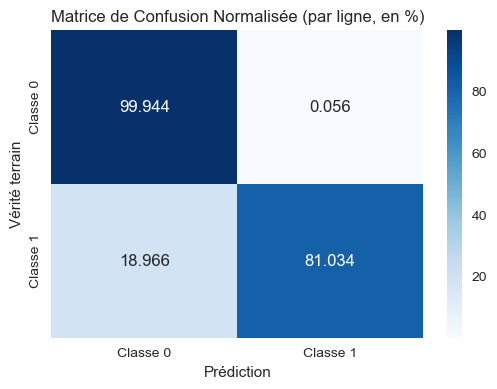

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.75      0.81      0.78        58

    accuracy                           1.00     28699
   macro avg       0.87      0.90      0.89     28699
weighted avg       1.00      1.00      1.00     28699



In [69]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prédictions du modèle
y_pred = best_pipeline_KNN.predict(X_val)

# 2. Matrice de confusion normalisée par ligne (pourcentage par classe réelle)
conf_matrix_normalized = confusion_matrix(y_val, y_pred, normalize='true') * 100  # en %

# 3. Affichage de la matrice de confusion en pourcentage (ligne)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matrice de Confusion Normalisée (par ligne, en %)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

# 4. Rapport de classification
print("Rapport de classification :\n", classification_report(y_val, y_pred))



In [70]:
import dill

# Enregistrer le meilleur modèle avec dill
with open('best_KNN.dill', 'wb') as f:
    dill.dump(best_pipeline_KNN, f)
    
# Charger le modèle avec dill
with open('best_KNN.dill', 'rb') as f:
    loaded_model = dill.load(f)
# Effectuer une prédiction pour tester le modèle chargé
y_pred = loaded_model.predict(X_val)
print(y_pred)


[0 0 0 ... 0 0 0]


# Arbre de decision

## baseline

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# ----------------------------
# 1. Séparation des variables
# ----------------------------
X = df.drop('FraudResult', axis=1)
y = df['FraudResult']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# 2. Prétraitement
# ----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
])

# ----------------------------
# 0. Baseline (modèle par défaut)
# ----------------------------
print("📌 Baseline : Decision Tree sans tuning ni sampling")

baseline_pipeline = ImbPipeline([
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_val)
y_proba_baseline = baseline_pipeline.predict_proba(X_val)[:, 1]

print("➡️ Performance du modèle baseline :")
print(f"Accuracy  : {accuracy_score(y_val, y_pred_baseline):.4f}")
print(f"Précision : {precision_score(y_val, y_pred_baseline, zero_division=0):.4f}")
print(f"Rappel    : {recall_score(y_val, y_pred_baseline):.4f}")
print(f"F1-score  : {f1_score(y_val, y_pred_baseline):.4f}")
print(f"ROC AUC   : {roc_auc_score(y_val, y_proba_baseline):.4f}")

# ----------------------------
# Affichage des hyperparamètres par défaut
# ----------------------------
print("\n📋 Hyperparamètres par défaut de Decision Tree :")
for param, val in baseline_pipeline.named_steps['clf'].get_params().items():
    print(f"{param}: {val}")


📌 Baseline : Decision Tree sans tuning ni sampling
➡️ Performance du modèle baseline :
Accuracy  : 0.9995
Précision : 0.8909
Rappel    : 0.8448
F1-score  : 0.8673
ROC AUC   : 0.9309

📋 Hyperparamètres par défaut de Decision Tree :
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
random_state: 42
splitter: best


### Tuning and sampling with Arbre de decision

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# ----------------------------
# 1. Séparation des variables
# ----------------------------
X = df.drop('FraudResult', axis=1)
y = df['FraudResult']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# 2. Prétraitement dans un transformer unique
# ----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
])

# ----------------------------
# 3. Paramètres de recherche pour Decision Tree
# ----------------------------
param_grid = {
    'clf__criterion': ['gini', 'entropy'],  # Critère de décision
    'clf__max_depth': [5, 10],  # Profondeur maximale de l'arbre
    'clf__min_samples_split': [4, 8],  # Nombre minimal d'échantillons pour diviser un noeud
    'clf__min_samples_leaf': [3, 7],  # Nombre minimal d'échantillons dans une feuille
    'clf__max_features': [None, 'sqrt'],  # Nombre maximal de caractéristiques à considérer
    'clf__random_state': [42]  # Fixation de l'aléa pour reproductibilité
}

# Paramètres avec suréchantillonnage SMOTE
param_grid_smote = param_grid.copy()
param_grid_smote.update({
    'smote__sampling_strategy': [0.25, 0.5]
})

# Paramètres avec sous-échantillonnage
param_grid_under = param_grid.copy()
param_grid_under.update({
    'under__sampling_strategy': [0.25, 0.5]
})


# ----------------------------
# 4. Définition des pipelines imbriqués
# ----------------------------
pipelines = {
    "Original": ImbPipeline([
        ('preproc', preprocessor),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    "SMOTE": ImbPipeline([
        ('preproc', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    "UnderSampling": ImbPipeline([
        ('preproc', preprocessor),
        ('under', RandomUnderSampler(random_state=42)),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    "Pondération": ImbPipeline([
        ('preproc', preprocessor),
        ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced'))  # Pondération des classes
    ])
}

# ----------------------------
# 5. Boucle d’entraînement et évaluation
# ----------------------------
resultats = []

for methode, pipeline in pipelines.items():
    print(f"\n🔍 Méthode : {methode}")

    if "SMOTE" in methode:
        tuned_parameters = param_grid_smote
    elif "UnderSampling" in methode:
        tuned_parameters = param_grid_under
    else:
        tuned_parameters = param_grid
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    
    grid = GridSearchCV(pipeline, tuned_parameters, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    y_proba = best_model.predict_proba(X_val)[:, 1]  # Probabilités pour la classe 1

    resultats.append({
        'Méthode': methode,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Précision': precision_score(y_val, y_pred, zero_division=0),
        'Rappel': recall_score(y_val, y_pred),
        'F1-score': f1_score(y_val, y_pred),
        'ROC AUC': roc_auc_score(y_val, y_proba),
        'Best Params': grid.best_params_
    })

# ----------------------------
# 6. Résumé
# ----------------------------
df_resultats = pd.DataFrame(resultats)
df_resultats = df_resultats.sort_values(by='F1-score', ascending=False).reset_index(drop=True)

print("\n📊 Résumé des performances :")
print(df_resultats)



🔍 Méthode : Original

🔍 Méthode : SMOTE

🔍 Méthode : UnderSampling

🔍 Méthode : Pondération

📊 Résumé des performances :
         Méthode  Accuracy  Précision    Rappel  F1-score   ROC AUC  \
0       Original  0.999686   0.980392  0.862069  0.917431  0.965447   
1    Pondération  0.999617   0.898305  0.913793  0.905983  0.956879   
2          SMOTE  0.999408   0.805970  0.931034  0.864000  0.973970   
3  UnderSampling  0.989512   0.157746  0.965517  0.271186  0.980200   

                                         Best Params  
0  {'clf__criterion': 'entropy', 'clf__max_depth'...  
1  {'clf__criterion': 'entropy', 'clf__max_depth'...  
2  {'clf__criterion': 'entropy', 'clf__max_depth'...  
3  {'clf__criterion': 'gini', 'clf__max_depth': 5...  


## récupérer le pipeline optimal pour Arbre de decision

In [77]:

# Meilleurs hyperparamètres obtenus pour l'Arbre de Décision
best_params = df_resultats[df_resultats['Méthode'] == 'Original']['Best Params'].values[0]
print("Meilleurs hyperparamètres : ", best_params)

# Reconstruire le pipeline final avec Arbre de Décision et original
best_pipeline_tree = ImbPipeline([
    ('preproc', preprocessor), 
    ('clf', DecisionTreeClassifier(
        criterion=best_params['clf__criterion'],  # Critère pour l'arbre
        max_depth=best_params['clf__max_depth'],  # Profondeur maximale
        max_features=best_params['clf__max_features'],  # Nombre de caractéristiques à considérer pour chaque scission
        min_samples_leaf=best_params['clf__min_samples_leaf'],  # Nombre minimal d'échantillons par feuille
        min_samples_split=best_params['clf__min_samples_split'],  # Nombre minimal d'échantillons pour scinder un noeud
        random_state=best_params['clf__random_state']  # Fixer la graine pour la reproductibilité
    ))
])

# Entraîner le pipeline final
best_pipeline_tree.fit(X_train, y_train)



Meilleurs hyperparamètres :  {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': None, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 4, 'clf__random_state': 42}


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Value',
                                                   'SubscriptionId_transaction_count',
                                                   'CustomerId_abs_amount_std',
                                                   'log_CustomerId_abs_amount_sum',
                                                   'Amount_Value_Ecart']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['ProviderId', 'ProductId', 'ChannelId', 'PricingStrategy',
       'TransactionType', 'TransactionDay', 'MomentOfDay'],
      dtype='object'))])),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=3, min_samples_split=4,
                                        random_state=42))])

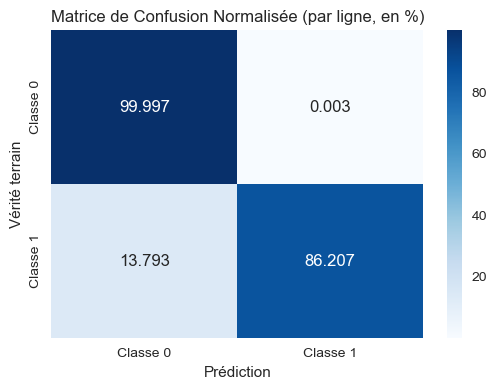

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.98      0.86      0.92        58

    accuracy                           1.00     28699
   macro avg       0.99      0.93      0.96     28699
weighted avg       1.00      1.00      1.00     28699



In [78]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prédictions sur l'ensemble de test
y_pred = best_pipeline_tree.predict(X_val)

# 2. Matrice de confusion normalisée par ligne (pourcentage par classe réelle)
conf_matrix_normalized = confusion_matrix(y_val, y_pred, normalize='true') * 100  # en %

# 3. Affichage de la matrice de confusion normalisée en pourcentage
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matrice de Confusion Normalisée (par ligne, en %)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

# 4. Affichage du rapport de classification
print("Rapport de classification :\n", classification_report(y_val, y_pred))


In [79]:
import dill

# Enregistrer le meilleur modèle avec dill
with open('best_Tree.dill', 'wb') as f:
    dill.dump(best_pipeline_tree, f)
    
# Charger le modèle avec dill
with open('best_Tree.dill', 'rb') as f:
    loaded_model = dill.load(f)
# Effectuer une prédiction pour tester le modèle chargé
y_pred = loaded_model.predict(X_val)
print(y_pred)


[0 0 0 ... 0 0 0]


# Modeles ensemblistes

## Modeles parallels : RandomForest

### Baseline

In [83]:

from sklearn.ensemble import RandomForestClassifier
# ----------------------------
# 0. Baseline (modèle par défaut)
# ----------------------------
print("📌 Baseline : RandomForest sans tuning ni sampling")

baseline_pipeline = ImbPipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_val)
y_proba_baseline = baseline_pipeline.predict_proba(X_val)[:, 1]

print("➡️ Performance du modèle baseline :")
print(f"Accuracy  : {accuracy_score(y_val, y_pred_baseline):.4f}")
print(f"Précision : {precision_score(y_val, y_pred_baseline, zero_division=0):.4f}")
print(f"Rappel    : {recall_score(y_val, y_pred_baseline):.4f}")
print(f"F1-score  : {f1_score(y_val, y_pred_baseline):.4f}")
print(f"ROC AUC   : {roc_auc_score(y_val, y_proba_baseline):.4f}")

print("\n📋 Hyperparamètres par défaut du RandomForest :")
for param, val in baseline_pipeline.named_steps['clf'].get_params().items():
    print(f"{param}: {val}")


📌 Baseline : RandomForest sans tuning ni sampling
➡️ Performance du modèle baseline :
Accuracy  : 0.9993
Précision : 0.8679
Rappel    : 0.7931
F1-score  : 0.8288
ROC AUC   : 0.9998

📋 Hyperparamètres par défaut du RandomForest :
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


### Tuning and sampling with RandomForest

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# ----------------------------
# 1. Séparation des variables
# ----------------------------
X = df.drop('FraudResult', axis=1)
y = df['FraudResult']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# 2. Prétraitement dans un transformer unique
# ----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
])

# ----------------------------
# 3. Paramètres de recherche pour RandomForest
# ----------------------------
param_grid = {
    'clf__n_estimators': [200, 300],  # Nombre d'arbres
    'clf__max_depth': [10, 20],  # Profondeur maximale
    'clf__min_samples_split': [5, 10],  # Nombre minimal d'échantillons pour diviser un noeud
    'clf__min_samples_leaf': [2, 4],  # Nombre minimal d'échantillons dans une feuille
    'clf__max_features': [None],  # Nombre maximal de caractéristiques
    'clf__random_state': [42]  # Fixation de l'aléa pour reproductibilité
}

# Paramètres avec suréchantillonnage SMOTE
param_grid_smote = param_grid.copy()
param_grid_smote.update({
    'smote__sampling_strategy': [0.25, 0.5]
})

# Paramètres avec sous-échantillonnage
param_grid_under = param_grid.copy()
param_grid_under.update({
    'under__sampling_strategy': [0.25, 0.5]
})


# ----------------------------
# 4. Définition des pipelines imbriqués pour RandomForest
# ----------------------------
pipelines = {
    "RandomForest_Original": ImbPipeline([
        ('preproc', preprocessor),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    "RandomForest_SMOTE": ImbPipeline([
        ('preproc', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    "RandomForest_UnderSampling": ImbPipeline([
        ('preproc', preprocessor),
        ('under', RandomUnderSampler(random_state=42)),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    "Pondération": ImbPipeline([
        ('preproc', preprocessor),
        ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))  # Pondération des classes
   ])     
}

# ----------------------------
# 5. Boucle d’entraînement et évaluation pour RandomForest
# ----------------------------
resultats = []

for methode, pipeline in pipelines.items():
    print(f"\n🔍 Méthode : {methode}")

    if "SMOTE" in methode:
        tuned_parameters = param_grid_smote
    elif "UnderSampling" in methode:
        tuned_parameters = param_grid_under
    else:
        tuned_parameters = param_grid
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    
    grid = GridSearchCV(pipeline, tuned_parameters, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    y_proba = best_model.predict_proba(X_val)[:, 1]  # Probabilités pour la classe 1

    resultats.append({
        'Méthode': methode,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Précision': precision_score(y_val, y_pred, zero_division=0),
        'Rappel': recall_score(y_val, y_pred),
        'F1-score': f1_score(y_val, y_pred),
        'ROC AUC': roc_auc_score(y_val, y_proba),
        'Best Params': grid.best_params_
    })

# ----------------------------
# 6. Résumé des résultats pour RandomForest
# ----------------------------
df_resultats = pd.DataFrame(resultats)
df_resultats = df_resultats.sort_values(by='F1-score', ascending=False).reset_index(drop=True)

print("\n📊 Résumé des performances pour RandomForest :")
print(df_resultats)



🔍 Méthode : RandomForest_Original

🔍 Méthode : RandomForest_SMOTE

🔍 Méthode : RandomForest_UnderSampling

🔍 Méthode : Pondération

📊 Résumé des performances pour RandomForest :
                      Méthode  Accuracy  Précision    Rappel  F1-score  \
0       RandomForest_Original  0.999617   0.960784  0.844828  0.899083   
1                 Pondération  0.999373   0.822581  0.879310  0.850000   
2          RandomForest_SMOTE  0.999199   0.777778  0.844828  0.809917   
3  RandomForest_UnderSampling  0.992787   0.216730  0.982759  0.355140   

    ROC AUC                                        Best Params  
0  0.982637  {'clf__max_depth': 10, 'clf__max_features': No...  
1  0.965329  {'clf__max_depth': 20, 'clf__max_features': No...  
2  0.973889  {'clf__max_depth': 10, 'clf__max_features': No...  
3  0.998846  {'clf__max_depth': 10, 'clf__max_features': No...  


## récupérer le pipeline optimal pour RandomForest

In [87]:

# Meilleurs hyperparamètres obtenus pour l'Arbre de Décision
best_params = df_resultats[df_resultats['Méthode'] == 'RandomForest_Original']['Best Params'].values[0]
print("Meilleurs hyperparamètres : ", best_params)

# Reconstruire le pipeline final avec Arbre de Décision et original
best_pipeline_RandomForest = ImbPipeline([
    ('preproc', preprocessor), 
    ('clf', RandomForestClassifier(
        n_estimators=best_params['clf__n_estimators'], 
        max_depth=best_params['clf__max_depth'], 
        max_features=best_params['clf__max_features'],  
        min_samples_leaf=best_params['clf__min_samples_leaf'], 
        min_samples_split=best_params['clf__min_samples_split'], 
        random_state=best_params['clf__random_state'] 
    ))
])

# Entraîner le pipeline final
best_pipeline_RandomForest.fit(X_train, y_train)



Meilleurs hyperparamètres :  {'clf__max_depth': 10, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'clf__random_state': 42}


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Value',
                                                   'SubscriptionId_transaction_count',
                                                   'CustomerId_abs_amount_std',
                                                   'log_CustomerId_abs_amount_sum',
                                                   'Amount_Value_Ecart']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['ProviderId', 'ProductId', 'ChannelId', 'PricingStrategy',
       'TransactionType', 'TransactionDay', 'MomentOfDay'],
      dtype='object'))])),
                ('clf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=200, random_state=42))])

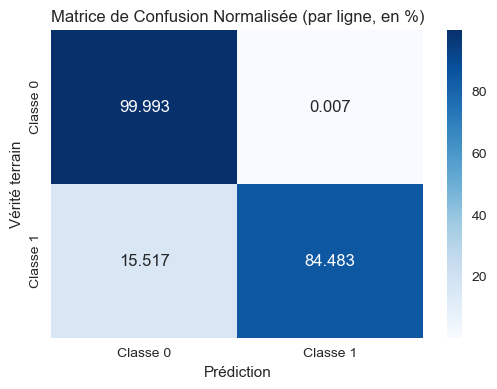

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.96      0.84      0.90        58

    accuracy                           1.00     28699
   macro avg       0.98      0.92      0.95     28699
weighted avg       1.00      1.00      1.00     28699



In [88]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prédictions sur l'ensemble de test
y_pred = best_pipeline_RandomForest.predict(X_val)

# 2. Matrice de confusion normalisée par ligne (pourcentage par classe réelle)
conf_matrix_normalized = confusion_matrix(y_val, y_pred, normalize='true') * 100  # en %

# 3. Affichage de la matrice de confusion normalisée en pourcentage
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matrice de Confusion Normalisée (par ligne, en %)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

# 4. Affichage du rapport de classification
print("Rapport de classification :\n", classification_report(y_val, y_pred))


In [89]:
import dill

# Enregistrer le meilleur modèle avec dill
with open('best_RandomForest.dill', 'wb') as f:
    dill.dump(best_pipeline_RandomForest, f)
    
# Charger le modèle avec dill
with open('best_RandomForest.dill', 'rb') as f:
    loaded_model = dill.load(f)
# Effectuer une prédiction pour tester le modèle chargé
y_pred = loaded_model.predict(X_val)
print(y_pred)


[0 0 0 ... 0 0 0]


## Modeles sequentiels : lightGBM

### Baseline

In [92]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# ----------------------------
# 1. Séparation des variables
# ----------------------------
X = df.drop('FraudResult', axis=1)
y = df['FraudResult']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# 2. Prétraitement
# ----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
])

# ----------------------------
# 0. Baseline (modèle par défaut)
# ----------------------------
print("📌 Baseline : LightGBM sans tuning ni sampling")

baseline_pipeline = ImbPipeline([
    ('preproc', preprocessor),
    ('clf', LGBMClassifier(random_state=42))
])

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_val)
y_proba_baseline = baseline_pipeline.predict_proba(X_val)[:, 1]

print("➡️ Performance du modèle baseline :")
print(f"Accuracy  : {accuracy_score(y_val, y_pred_baseline):.4f}")
print(f"Précision : {precision_score(y_val, y_pred_baseline, zero_division=0):.4f}")
print(f"Rappel    : {recall_score(y_val, y_pred_baseline):.4f}")
print(f"F1-score  : {f1_score(y_val, y_pred_baseline):.4f}")
print(f"ROC AUC   : {roc_auc_score(y_val, y_proba_baseline):.4f}")

# ----------------------------
# Affichage des hyperparamètres par défaut
# ----------------------------
print("\n📋 Hyperparamètres par défaut de LightGBM :")
for param, val in baseline_pipeline.named_steps['clf'].get_params().items():
    print(f"{param}: {val}")


📌 Baseline : LightGBM sans tuning ni sampling
[LightGBM] [Info] Number of positive: 135, number of negative: 66828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 66963, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002016 -> initscore=-6.204603
[LightGBM] [Info] Start training from score -6.204603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
➡️ Performance du modèle baseline :
Accuracy  : 0.9984
Précision : 0.5714
Rappel    : 0.7586
F1-score  : 0.6519
ROC AUC   : 0.8789

📋 Hyperparamètres par défaut de LightGBM :
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.1
max_depth: -1
min_child_samples: 20
min_child

### Tuning and sampling with LightGBM

In [94]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# ----------------------------
# 1. Séparation des variables
# ----------------------------
X = df.drop('FraudResult', axis=1)
y = df['FraudResult']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# 2. Prétraitement dans un transformer unique
# ----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
])

# ----------------------------
# 3. Paramètres de recherche pour LGBM
# ----------------------------
param_grid = {
    'clf__n_estimators': [200, 300],
    'clf__max_depth': [10, 20],
    'clf__learning_rate': [0.05, 0.2],
    'clf__num_leaves': [20, 40],
    'clf__random_state': [42]
}

# Paramètres avec SMOTE
param_grid_smote = param_grid.copy()
param_grid_smote.update({
    'smote__sampling_strategy': [0.25, 0.5]
})

# Paramètres avec sous-échantillonnage
param_grid_under = param_grid.copy()
param_grid_under.update({
    'under__sampling_strategy': [0.25, 0.5]
})

# ----------------------------
# 4. Définition des pipelines pour LGBM
# ----------------------------
pipelines = {
    "LightGBM_Original": ImbPipeline([
        ('preproc', preprocessor),
        ('clf', LGBMClassifier(random_state=42))
    ]),
    "LightGBM_SMOTE": ImbPipeline([
        ('preproc', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', LGBMClassifier(random_state=42))
    ]),
    "LightGBM_UnderSampling": ImbPipeline([
        ('preproc', preprocessor),
        ('under', RandomUnderSampler(random_state=42)),
        ('clf', LGBMClassifier(random_state=42))
    ]),
    "Pondération": ImbPipeline([
        ('preproc', preprocessor),
        ('clf', LGBMClassifier(random_state=42, class_weight='balanced'))
    ])
}

# ----------------------------
# 5. Boucle d’entraînement et évaluation pour LGBM
# ----------------------------
resultats = []

for methode, pipeline in pipelines.items():
    print(f"\n🔍 Méthode : {methode}")

    if "SMOTE" in methode:
        tuned_parameters = param_grid_smote
    elif "UnderSampling" in methode:
        tuned_parameters = param_grid_under
    else:
        tuned_parameters = param_grid
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    
    grid = GridSearchCV(pipeline, tuned_parameters, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    y_proba = best_model.predict_proba(X_val)[:, 1]

    resultats.append({
        'Méthode': methode,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Précision': precision_score(y_val, y_pred, zero_division=0),
        'Rappel': recall_score(y_val, y_pred),
        'F1-score': f1_score(y_val, y_pred),
        'ROC AUC': roc_auc_score(y_val, y_proba),
        'Best Params': grid.best_params_
    })

# ----------------------------
# 6. Résumé des résultats pour LGBM
# ----------------------------
df_resultats = pd.DataFrame(resultats)
df_resultats = df_resultats.sort_values(by='F1-score', ascending=False).reset_index(drop=True)

print("\n📊 Résumé des performances pour LightGBM :")
print(df_resultats)



🔍 Méthode : LightGBM_Original
[LightGBM] [Info] Number of positive: 135, number of negative: 66828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 66963, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002016 -> initscore=-6.204603
[LightGBM] [Info] Start training from score -6.204603

🔍 Méthode : LightGBM_SMOTE
[LightGBM] [Info] Number of positive: 16707, number of negative: 66828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5973
[LightGBM] [Info] Number of data points in the train s

## récupérer le pipeline optimal pour LightGBM

In [96]:
import lightgbm as lgb
from imblearn.pipeline import Pipeline as ImbPipeline  # Assure-toi d'importer la bonne classe Pipeline

# Meilleurs hyperparamètres obtenus pour LightGBM
best_params = df_resultats[df_resultats['Méthode'] == 'LightGBM_SMOTE']['Best Params'].values[0]
print("Meilleurs hyperparamètres : ", best_params)

# Reconstruire le pipeline final avec LightGBM
best_pipeline_LightGBM = ImbPipeline([
    ('preproc', preprocessor),  
    ('smote', SMOTE(sampling_strategy=best_params['smote__sampling_strategy'])),  # Application de SMOTE
    ('clf', lgb.LGBMClassifier(
        learning_rate=best_params['clf__learning_rate'],  # Taux d'apprentissage
        max_depth=best_params['clf__max_depth'],          # Profondeur maximale des arbres
        n_estimators=best_params['clf__n_estimators'],    # Nombre d'arbres
        num_leaves=best_params['clf__num_leaves'],        # Nombre de feuilles par arbre
        random_state=best_params['clf__random_state']     # Pour la reproductibilité
    ))
])

# Entraîner le pipeline final
best_pipeline_LightGBM.fit(X_train, y_train)



Meilleurs hyperparamètres :  {'clf__learning_rate': 0.2, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__num_leaves': 20, 'clf__random_state': 42, 'smote__sampling_strategy': 0.25}
[LightGBM] [Info] Number of positive: 16707, number of negative: 66828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5988
[LightGBM] [Info] Number of data points in the train set: 83535, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Value',
                                                   'SubscriptionId_transaction_count',
                                                   'CustomerId_abs_amount_std',
                                                   'log_CustomerId_abs_amount_sum',
                                                   'Amount_Value_Ecart']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['ProviderId', 'ProductId', 'ChannelId', 'PricingStrategy',
       'TransactionType', 'TransactionDay', 'MomentOfDay'],
      dtype='object'))])),
                ('smote', SMOTE(sampling_strategy=0.25)),
                ('clf',
                 LGBMClassifier(learning_rate=0.2, max_depth=10,
                                n_estimators=200, num_leaves=20,
                                random_state=42))])

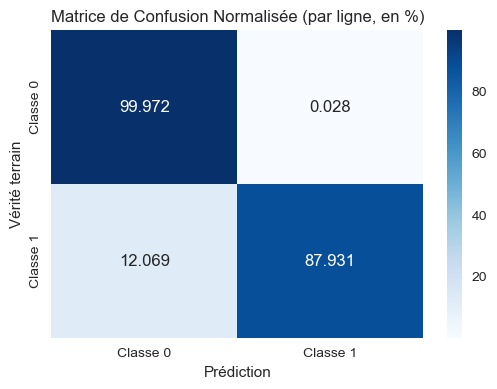

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.86      0.88      0.87        58

    accuracy                           1.00     28699
   macro avg       0.93      0.94      0.94     28699
weighted avg       1.00      1.00      1.00     28699



In [97]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prédictions sur l'ensemble de test
y_pred = best_pipeline_LightGBM.predict(X_val)

# 2. Matrice de confusion normalisée par ligne (pourcentage par classe réelle)
conf_matrix_normalized = confusion_matrix(y_val, y_pred, normalize='true') * 100  # en %

# 3. Affichage de la matrice de confusion normalisée en pourcentage
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matrice de Confusion Normalisée (par ligne, en %)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

# 4. Affichage du rapport de classification
print("Rapport de classification :\n", classification_report(y_val, y_pred))

In [194]:
import dill

# Enregistrer le meilleur modèle avec dill
with open('best_SMOTE_LightGBM.dill', 'wb') as f:
    dill.dump(best_pipeline_LightGBM, f)
    
# Charger le modèle avec dill
with open('best_SMOTE_LightGBM.dill', 'rb') as f:
    loaded_model = dill.load(f)
# Effectuer une prédiction pour tester le modèle chargé
y_pred = loaded_model.predict(X_val)
print(y_pred)


[0 0 0 ... 0 0 0]
